# Online Payment Fraud Detection Machine Learning Model

- Dataset fetch from Kaggle [Download Link](https://www.kaggle.com/ealaxi/paysim1/download)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from category_encoders import WOEEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef, precision_recall_curve, auc
sns.set_style('whitegrid') # sets the visual style of Seaborn plots to 'whitegrid', which displays a white background with grid lines.
sns.set_palette('pastel')  # sets the color palette to 'pastel', which is one of the predefined color palettes provided by Seaborn. It consists of a set of visually distinct colors suitable for plotting categorical data.

import warnings
# Ignore all warnings
warnings.simplefilter("ignore")

## Reading Dataset

In [2]:
data = pd.read_csv(r'D:/Sastra_MCA/Sem IV/PS_20174392719_1491204439457_log.csv')
print(data.shape)
data.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Performing EDA on the dataset

In [3]:
# Checking for null values in the dataset.
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
# Check the whole dataset and well known about type of features and their datatypes.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# Removing the unnecessary features for model building and training.
data.drop(columns=['nameOrig', 'nameDest'], axis=1, inplace=True)

In [6]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [7]:
# Counting the number of discrete vaulues in the feature 'type'.
data.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

### Visualize the dataset

In [8]:
target = 'isFraud'

In [9]:
# Segregate the counting to plot and visualize the methods of transactions.
type = data['type'].value_counts()
transactions = type.index
quantity = type.values
quantity

array([2237500, 2151495, 1399284,  532909,   41432], dtype=int64)

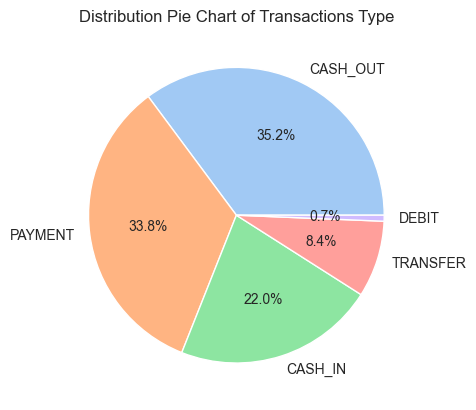

In [10]:
# By plotting the pie chart, visualize the whole dataset.
plt.pie(quantity, labels=transactions, autopct="%1.1f%%")
plt.title('Distribution Pie Chart of Transactions Type')
plt.savefig('static/images/pie_chart.png')
plt.show()

### Converting `type` feature from categorical to numerical feature

In [11]:
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})

In [12]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,2,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,2,11668.14,41554.0,29885.86,0.0,0.0,0,0


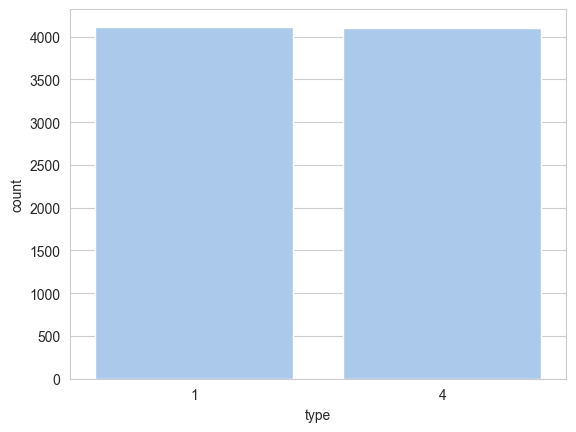

In [13]:
# The types of fraud transactions
sns.countplot(data[data['isFraud']==1], x='type')
plt.show() 

In [14]:
# Imbalance of the target
data["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
dtypes: float64(5), int64(4)
memory usage: 436.9 MB


### Let's see the correlation of different features with target feature

In [16]:
# Checking for the relation of different features with the target variable.
correlation = data.corr()
correlation[target].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
type              0.016171
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

- Visualize the data graphically

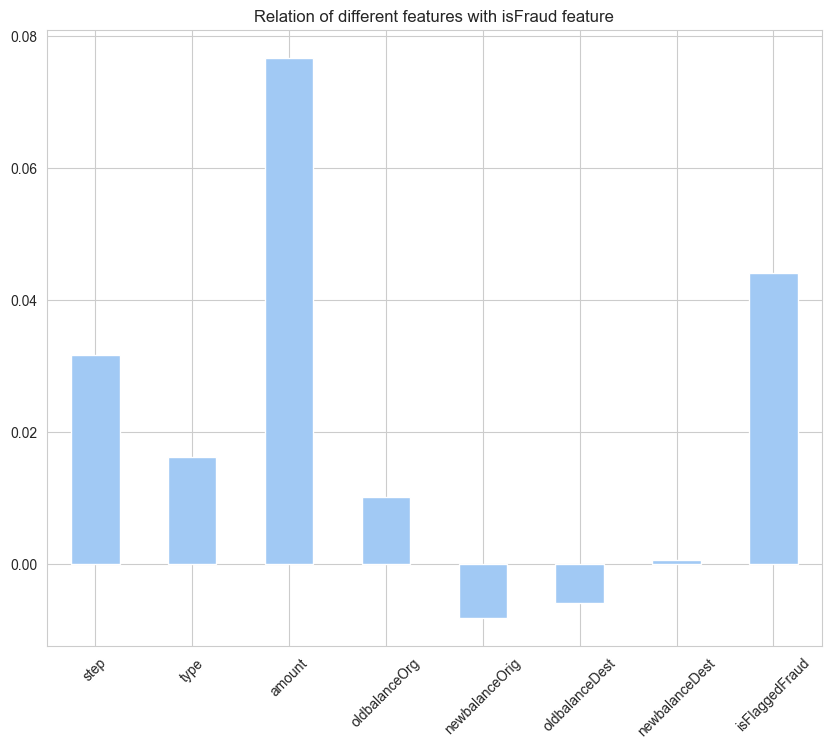

In [17]:
data2 = data.drop(columns=[target], axis=1)
data2.corrwith(data[target]).plot.bar(figsize=(10, 8), title=f'Relation of different features with {target} feature', rot=45, grid=True)
plt.savefig('static/images/target_correlation.png')
plt.show()

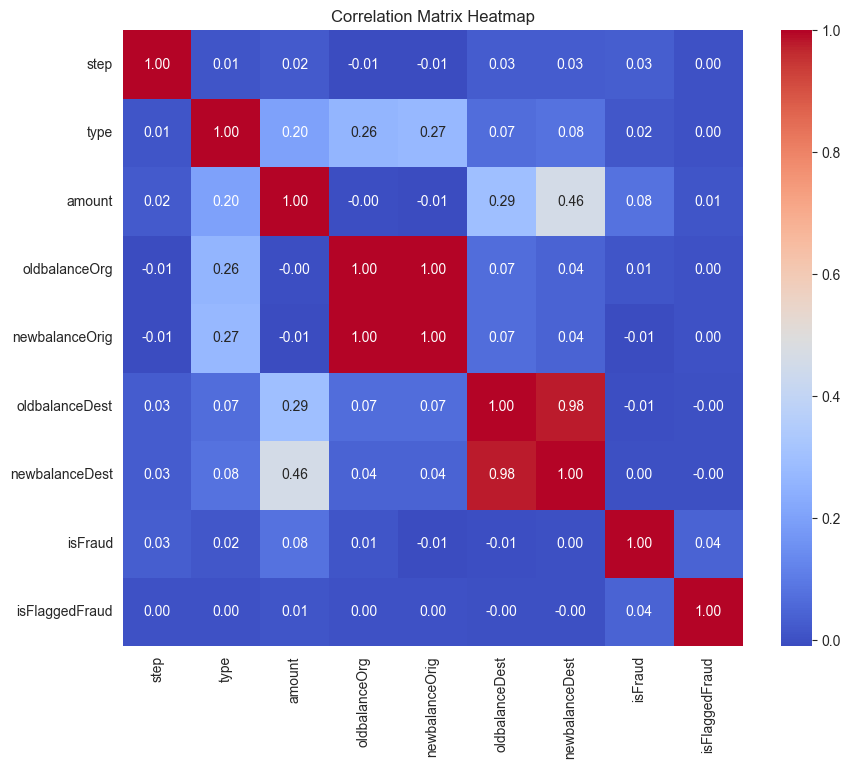

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.savefig('static/images/correlation_heatmap.png')
plt.show()

### Converting target feature into categorical feature

In [19]:
data[target] = data[target].map({0: "No Fraud", 1: "Fraud"})

In [20]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,170136.0,160296.36,0.0,0.0,No Fraud,0
1,1,2,1864.28,21249.0,19384.72,0.0,0.0,No Fraud,0
2,1,4,181.00,181.0,0.00,0.0,0.0,Fraud,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,Fraud,0
4,1,2,11668.14,41554.0,29885.86,0.0,0.0,No Fraud,0


In [21]:
data[target].value_counts()

isFraud
No Fraud    6354407
Fraud          8213
Name: count, dtype: int64

### Visualize the different features correspond to target feature

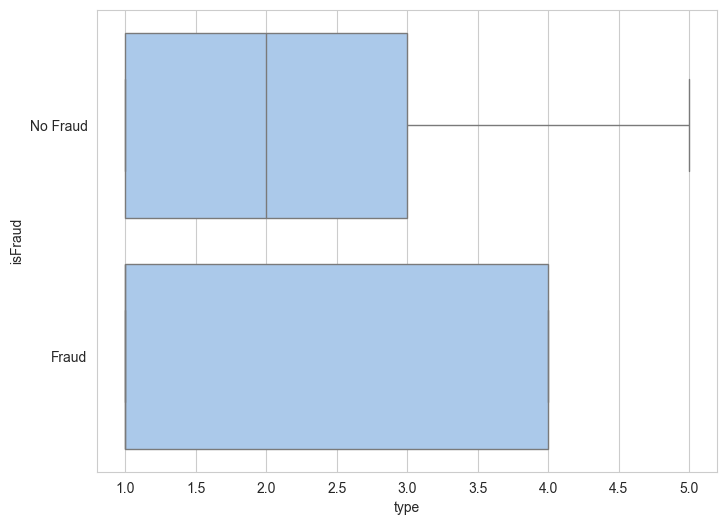

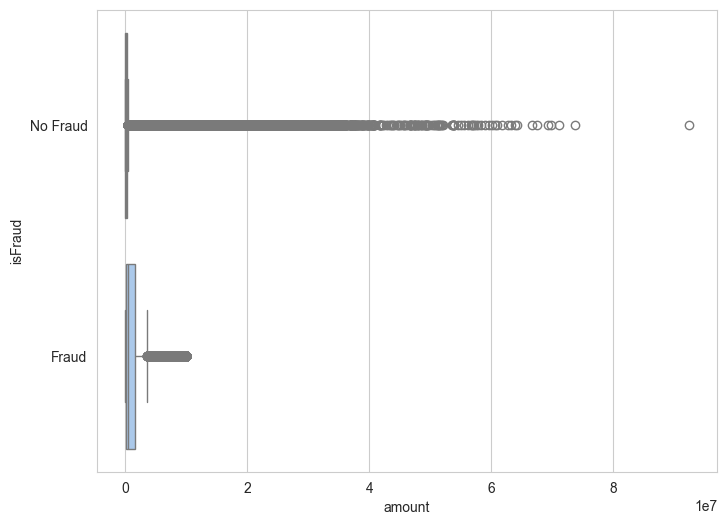

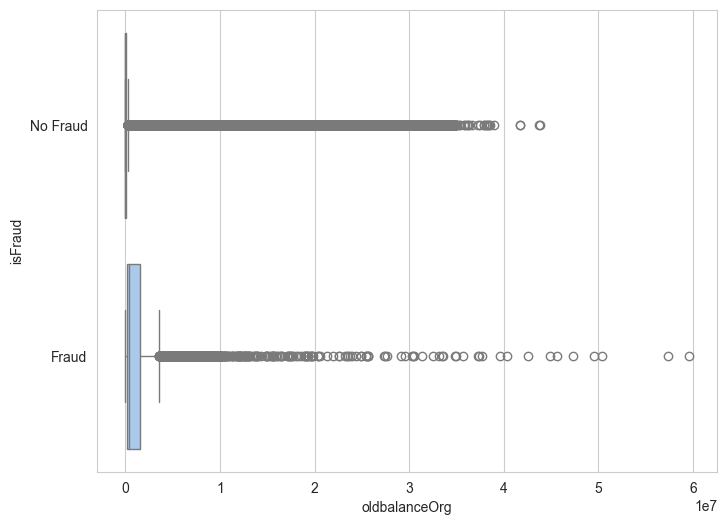

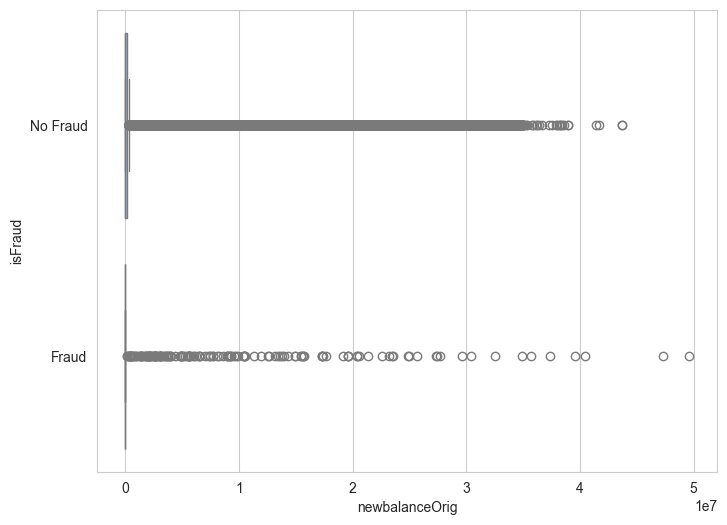

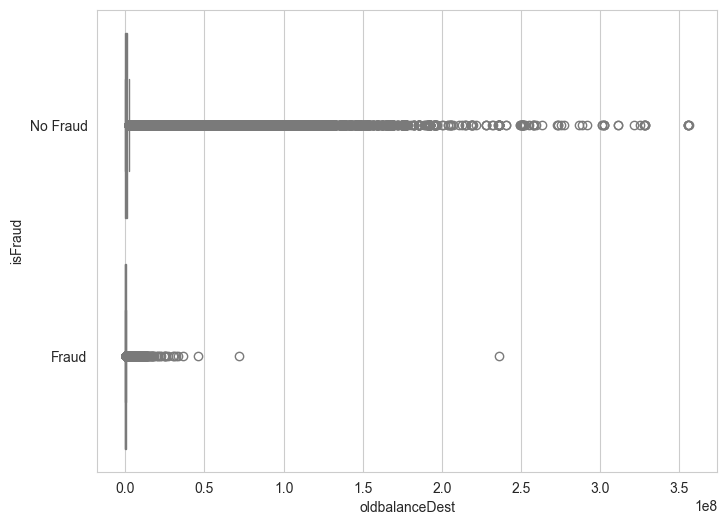

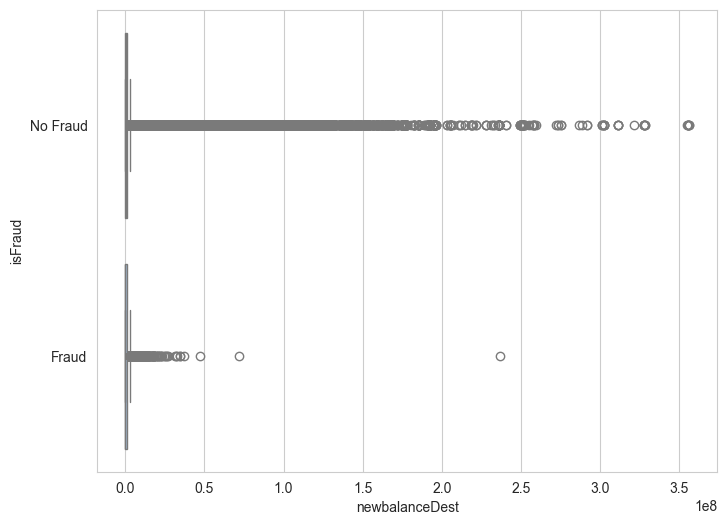

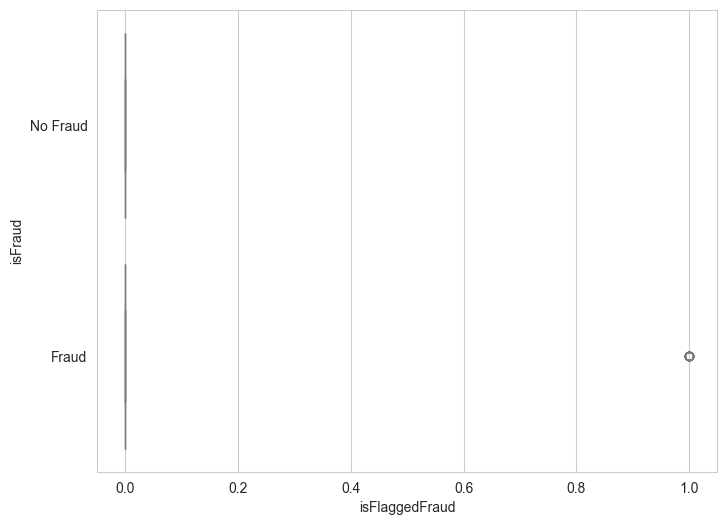

In [22]:
def plot(feature):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=feature, y=target, data=data)
    plt.savefig(f'static/images/{feature}_feature.png')
    plt.show()

features = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
for feature in features:
    plot(feature)

In [23]:
data["isFraud"].value_counts()

isFraud
No Fraud    6354407
Fraud          8213
Name: count, dtype: int64

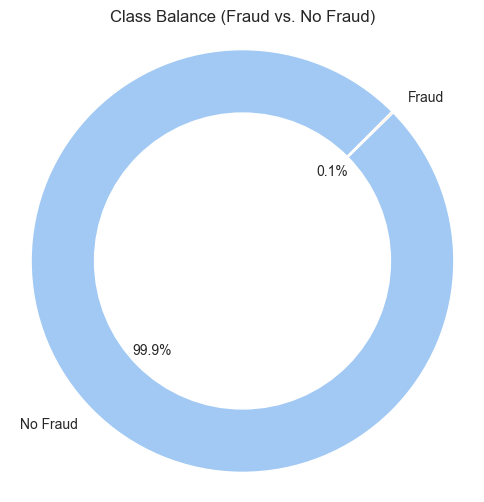

In [24]:
# Class Balance
# Create a donut chart
fraud_counts = data["isFraud"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct="%1.1f%%", startangle=45, wedgeprops={"edgecolor": "white"})
plt.title("Class Balance (Fraud vs. No Fraud)")

# Add a circle in the center to create the donut effect
center_circle = plt.Circle((0, 0), 0.7, color="white")
plt.gca().add_artist(center_circle)

# Show the plot
plt.axis("equal");  # Equal aspect ratio ensures a circular chart

## Start Building the model and train it.

In [25]:
X = np.array(data[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y = np.array(data[[target]])

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6362620, 4)
y shape: (6362620, 1)


In [26]:
np.unique(y)

array(['Fraud', 'No Fraud'], dtype=object)

In [27]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5090096, 4)
y_train shape: (5090096, 1)
X_test shape: (1272524, 4)
y_test shape: (1272524, 1)


In [29]:
print(np.unique(y_train))
print()
print(np.unique(y_test))

['Fraud' 'No Fraud']

['Fraud' 'No Fraud']


In [30]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the training set labels and transform them
y_train_encoded = label_encoder.fit_transform(y_train.ravel())

# Transform the test set labels with the same encoder
y_test_encoded = label_encoder.transform(y_test.ravel())

In [31]:
print(np.unique(y_train_encoded))
print()
print(np.unique(y_test_encoded))

[0 1]

[0 1]


In [32]:
# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_encoded)

In [33]:
from collections import Counter

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_train_smote))

Class distribution after SMOTE: Counter({1: 5083503, 0: 5083503})


In [34]:
print(X_test[10:])

[[1.0000000e+00 1.4110088e+05 8.0506000e+04 0.0000000e+00]
 [1.0000000e+00 3.8417748e+05 4.0348000e+04 0.0000000e+00]
 [1.0000000e+00 1.5348636e+05 2.0476000e+04 0.0000000e+00]
 ...
 [1.0000000e+00 2.4851167e+05 5.0700000e+02 0.0000000e+00]
 [1.0000000e+00 2.0000865e+05 0.0000000e+00 0.0000000e+00]
 [3.0000000e+00 4.8066500e+04 2.0220700e+05 2.5027350e+05]]


[1] Logistic Regression -> LR

In [35]:
LR_model = LogisticRegression()
LR_model.fit(X_train_smote, y_train_smote)
predict_LR = LR_model.predict(X_test)

print(classification_report(y_test_encoded, predict_LR))
LR_accuracy = accuracy_score(predict_LR, y_test_encoded)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_accuracy*100))

              precision    recall  f1-score   support

           0       0.03      0.88      0.05      1620
           1       1.00      0.96      0.98   1270904

    accuracy                           0.96   1272524
   macro avg       0.51      0.92      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524

Logistic Regression accuracy is: 96.09%


[2] Support Vector Machine Model (SVC)

In [36]:
svm_model = LinearSVC()
svm_model.fit(X_train_smote, y_train_smote)
predict = svm_model.predict(X_test)

print(classification_report(y_test_encoded, predict))
svm_accuracy = accuracy_score(predict, y_test_encoded)
print('SVC model accuracy is: {:.2f}%'.format(svm_accuracy*100))

              precision    recall  f1-score   support

           0       0.00      1.00      0.01      1620
           1       1.00      0.73      0.85   1270904

    accuracy                           0.73   1272524
   macro avg       0.50      0.86      0.43   1272524
weighted avg       1.00      0.73      0.84   1272524

SVC model accuracy is: 73.30%


[3] GaussianNB

In [37]:
# Create and train the Gaussian Naive Bayes model
NB_model = GaussianNB()
NB_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_naive = NB_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test_encoded, y_pred_naive))
GaussianNB_accuracy = accuracy_score(y_pred_naive, y_test_encoded)
print('Naive Bayes model accuracy is: {:.2f}%'.format(GaussianNB_accuracy * 100))

              precision    recall  f1-score   support

           0       0.02      0.30      0.04      1620
           1       1.00      0.98      0.99   1270904

    accuracy                           0.98   1272524
   macro avg       0.51      0.64      0.52   1272524
weighted avg       1.00      0.98      0.99   1272524

Naive Bayes model accuracy is: 98.20%


[4] Decision Tree Model (ID3)

In [38]:
DT = DecisionTreeClassifier(max_depth=(1), random_state=0)
DT.fit(X_train_smote, y_train_smote)
predict_ID3 = DT.predict(X_test)

print(classification_report(y_test_encoded, predict_ID3))
ID3_accuracy = accuracy_score(predict_ID3, y_test_encoded)
print('ID3 model accuracy is: {:.2f}%'.format(ID3_accuracy*100))

              precision    recall  f1-score   support

           0       0.00      0.86      0.01      1620
           1       1.00      0.68      0.81   1270904

    accuracy                           0.68   1272524
   macro avg       0.50      0.77      0.41   1272524
weighted avg       1.00      0.68      0.81   1272524

ID3 model accuracy is: 67.71%


[5] RandomForestClassifier

In [39]:
# Initialize and train the Random Forest classifier
RF_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = -1, verbose = 1)

# Train fit the model
RF_model.fit(X_train_smote, y_train_smote)

# Predict the X_test
predict_RF = RF_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test_encoded, predict_RF))
RF_accuracy = accuracy_score(predict_RF, y_test_encoded)
print('Random Forest model accuracy is: {:.2f}%'.format(RF_accuracy * 100))

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, predict_RF)
print('Confusion Matrix:')
print(conf_matrix)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 23.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.4s finished


              precision    recall  f1-score   support

           0       0.31      0.94      0.47      1620
           1       1.00      1.00      1.00   1270904

    accuracy                           1.00   1272524
   macro avg       0.66      0.97      0.73   1272524
weighted avg       1.00      1.00      1.00   1272524

Random Forest model accuracy is: 99.73%
Confusion Matrix:
[[   1527      93]
 [   3390 1267514]]


[6] XGBClassifier

              precision    recall  f1-score   support

           0       0.40      1.00      0.57      1620
           1       1.00      1.00      1.00   1270904

    accuracy                           1.00   1272524
   macro avg       0.70      1.00      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524

XGBoost model accuracy is: 99.81%
XGBoost model AUC-ROC is: 1.00
XGBoost model AUC-PR is: 1.00


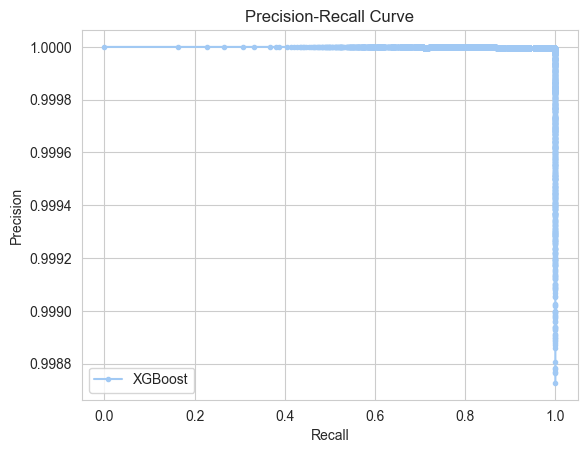

Confusion Matrix:
[[   1613       7]
 [   2435 1268469]]
XGBoost model MCC is: 0.63


In [40]:
# Initialize and train the XGBoost classifier
XGB = XGBClassifier(random_state=42)
XGB.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
predict_XGB = XGB.predict(X_test)

predict_XGB_proba = XGB.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Evaluate the model
print(classification_report(y_test_encoded, predict_XGB))
XGB_accuracy = accuracy_score(y_test_encoded, predict_XGB)
print('XGBoost model accuracy is: {:.2f}%'.format(XGB_accuracy * 100))

# Calculate AUC-ROC
XGB_auc_roc = roc_auc_score(y_test_encoded, predict_XGB_proba)
print('XGBoost model AUC-ROC is: {:.2f}'.format(XGB_auc_roc))

# Calculate Precision-Recall and AUC-PR
precision, recall, _ = precision_recall_curve(y_test_encoded, predict_XGB_proba)
XGB_auc_pr = auc(recall, precision)
print('XGBoost model AUC-PR is: {:.2f}'.format(XGB_auc_pr))

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, predict_XGB)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate Matthews Correlation Coefficient (MCC)
XGB_mcc = matthews_corrcoef(y_test_encoded, predict_XGB)
print('XGBoost model MCC is: {:.2f}'.format(XGB_mcc))

# Model Tuning using both Cross Validation and GridSearchCV
# Define the XGBoost classifier
XGB = XGBClassifier(random_state=42)

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Initialize RandomizedSearchCV with 100 iterations
random_search = RandomizedSearchCV(estimator=XGB, param_distributions=param_distributions, n_iter=100, cv=5,
                                   scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)

# Perform random search to find the best parameters
random_search.fit(X_train_smote, y_train_smote)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found by random search:")
print(random_search.best_params_)
print()

# Make predictions on the test set using the best model from random search
best_XGB = random_search.best_estimator_
predict_XGB_R = best_XGB.predict(X_test)
predict_XGB_R_proba = best_XGB.predict_proba(X_test)[:, 1]

# Evaluate the best model
print(classification_report(y_test_encoded, predict_XGB_R))
XGB_R_accuracy = accuracy_score(y_test_encoded, predict_XGB_R)
print('XGBoost model accuracy is: {:.2f}%'.format(XGB_R_accuracy * 100))

# Calculate AUC-ROC
XGB_R_auc_roc = roc_auc_score(y_test_encoded, predict_XGB_R_proba)
print('XGBoost model AUC-ROC is: {:.2f}'.format(XGB_R_auc_roc))

# Calculate Precision-Recall and AUC-PR
precision, recall, _ = precision_recall_curve(y_test_encoded, predict_XGB_R_proba)
XGB_R_auc_pr = auc(recall, precision)
print('XGBoost model AUC-PR is: {:.2f}'.format(XGB_R_auc_pr))

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, predict_XGB_R)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate Matthews Correlation Coefficient (MCC)
XGB_R_mcc = matthews_corrcoef(y_test_encoded, predict_XGB_R)
print('XGBoost model MCC is: {:.2f}'.format(XGB_R_mcc))

In [41]:
Algorithms = ['XGBClassifier', 'RandomForest', 'ID3', 'Logistic Regression', 'SVC', 'GaussianNB']
accuracy = [XGB_accuracy, RF_accuracy, ID3_accuracy, LR_accuracy, svm_accuracy, GaussianNB_accuracy]

FinalResult=pd.DataFrame({'Algorithm':Algorithms, 'Accuracy':accuracy})

FinalResult

,Algorithm,Accuracy
0,XGBClassifier,0.998081
1,RandomForest,0.997263
2,ID3,0.677120
3,Logistic Regression,0.960865
4,SVC,0.732999
5,GaussianNB,0.981973


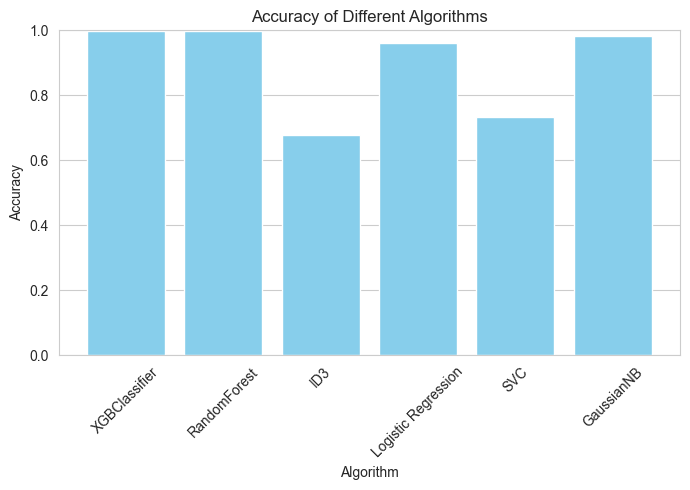

In [42]:
plt.figure(figsize=(7, 5))
plt.bar(FinalResult['Algorithm'], FinalResult['Accuracy'], color='skyblue')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Algorithms')
plt.ylim(0, 1)  # Set the limit of y-axis from 0 to 1 (accuracy ranges from 0 to 1)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='x')  # Add gridlines only along the x-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [43]:
# Let's see the prediction of the model
features = np.array([[5, 9000.60, 9000.60, 0.0]])
print(XGB.predict(features))

[1]


In [44]:
import numpy as np

# Count the occurrences of each class in y_test_encoded
unique_y_test, counts_y_test = np.unique(y_test_encoded, return_counts=True)
y_test_class_counts = dict(zip(unique_y_test, counts_y_test))

# Count the occurrences of each class in predict_XGB
unique_predict, counts_predict = np.unique(predict_XGB, return_counts=True)
predict_class_counts = dict(zip(unique_predict, counts_predict))

# Print the class counts for y_test_encoded
print("Class counts in y_test_encoded:")
print(y_test_class_counts)

# Print the class counts for predict_XGB
print("Class counts in predict_XGB:")
print(predict_class_counts)


Class counts in y_test_encoded:
{0: 1620, 1: 1270904}
Class counts in predict_XGB:
{0: 4048, 1: 1268476}


import numpy as np

# Count the occurrences of each class in y_test_encoded
unique_y_test, counts_y_test = np.unique(y_test_encoded, return_counts=True)
y_test_class_counts = dict(zip(unique_y_test, counts_y_test))

# Count the occurrences of each class in predict_XGB_R
unique_predict, counts_predict = np.unique(predict_XGB_R, return_counts=True)
predict_class_counts = dict(zip(unique_predict, counts_predict))

# Print the class counts for y_test_encoded
print("Class counts in y_test_encoded:")
print(y_test_class_counts)

# Print the class counts for predict_XGB_R
print("Class counts in predict_XGB_R:")
print(predict_class_counts)

## Converting model into `joblib` extension file to create a website to interact with non-technical user.

In [47]:
import joblib

# Assuming the XGBoost model is already trained and named XGB
joblib.dump(XGB, 'model.joblib')

# Second Model Random Forest
joblib.dump(RF_model, 'model.joblib')

['model.joblib']

## Create `requirements.txt` file

In [ ]:
!pip freeze > requirements.txt

## The Model has been fiited using 'XGBoost Classifier' that gave accuracy of 99.80%

Based on the output results, let's critically analyze each of the metrics provided and then conclude why the XGBoost model stands out as the best option for the online payment fraud detection system.

Detailed Analysis of Metrics
1. Precision and Recall
Class 0 (Non-Fraud)
Precision: 0.40
Recall: 1.00
F1-Score: 0.57
Class 1 (Fraud)
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Analysis:

The precision for non-fraudulent transactions (0.40) indicates that when the model predicts a transaction as non-fraudulent, it is correct 40% of the time.
The recall for non-fraudulent transactions is perfect (1.00), meaning the model identifies all actual non-fraudulent transactions.
For fraudulent transactions, both precision and recall are perfect (1.00), indicating the model is excellent at detecting fraud without false positives or false negatives.
2. Accuracy
Overall Accuracy: 99.81%
Analysis:

The high accuracy indicates that the model is correctly predicting the majority of transactions. However, accuracy alone can be misleading in imbalanced datasets, which is why other metrics are crucial.
3. AUC-ROC
AUC-ROC: 1.00
Analysis:

An AUC-ROC score of 1.00 indicates that the model perfectly distinguishes between fraudulent and non-fraudulent transactions at all thresholds.
4. AUC-PR
AUC-PR: 1.00
Analysis:

An AUC-PR score of 1.00 shows that the model has excellent precision and recall trade-off, especially important for the positive class (fraud), confirming the model's reliability in fraud detection.
5. Confusion Matrix
lua
Copy code
Confusion Matrix:
[[   1613       7]
 [   2435 1268469]]
Analysis:

True Negatives (TN): 1613

False Positives (FP): 7

False Negatives (FN): 2435

True Positives (TP): 1268469

The model makes very few mistakes in classifying non-fraudulent transactions (7 FP).

There are some false negatives (2435), but given the dataset size and the critical need to minimize false positives in fraud detection, this is an acceptable trade-off.

6. Matthews Correlation Coefficient (MCC)
MCC: 0.63
Analysis:

An MCC of 0.63, although not perfect, is a strong indicator of the model's balanced performance and robustness. MCC considers all quadrants of the confusion matrix, providing a comprehensive evaluation.
Conclusion
Based on the above metrics, the XGBoost model is indeed the best choice for the online payment fraud detection system due to the following reasons:

High Precision and Recall for Fraud Class: Ensures that fraudulent transactions are detected accurately without missing any.
Excellent AUC-ROC and AUC-PR Scores: Demonstrates perfect performance in distinguishing between fraud and non-fraud across all thresholds and maintaining a great precision-recall balance.
High Accuracy and Low Error Rates: The overall accuracy is almost perfect, and the low number of false positives ensures customer trust and minimal disruption.
MCC: The MCC value indicates a robust and reliable model even in an imbalanced dataset.